Importing necessary libraries and functions

In [377]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from subprocess import call
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from IPython.display import Image

%matplotlib inline

Display multiple outputs for each cell

In [101]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [102]:
data = pd.read_csv("../dat/online_shoppers_intention.csv.gz")

## EDA

In [103]:
data.shape
data.head()

(12330, 18)

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  
2        1       9            3  Returning_Visitor    False    False  
3        2       2            4  Returning_Visitor    False    False  
4        3       1            4  Returning_Visitor     True    False

In [104]:
data.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

The source of this dataset states that there are 10 numerical and 8 categorical variables, which would suggest that some of the float- or integer-valued columns should be treated as categorical.

Based on the column descriptions, the numerical columns are *Administrative*, *Administrative_Duration*, *Informational*, *Informational_Duration*, *ProductRelated*, *ProductRelated_Duration*, *BounceRates*, *ExitRates*, *PageValues*, *SpecialDay* and the categorical columns are *Month*, *OperatingSystems*, *Browser*, *Region*, *TrafficType*, *VisitorType*, *Weekend*, and *Revenue*. 

*Revenue* is the target variable, so predicting it would be a binary classification task.

In [105]:
num_cols = ["Administrative", "Administrative_Duration", "Informational",
            "Informational_Duration", "ProductRelated", "ProductRelated_Duration",
            "BounceRates", "ExitRates", "PageValues", "SpecialDay"]

# Excluding Revenue because it's the target variable
cat_cols = ["Month", "OperatingSystems", "Browser", "Region", "TrafficType",
            "VisitorType", "Weekend"]

In [137]:
data[num_cols].describe()

Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         2.315166                80.818611       0.503569   
std          3.321784               176.779107       1.270156   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 7.500000       0.000000   
75%          4.000000                93.256250       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            12330.000000    12330.000000             12330.000000   
mean                34.472398       31.731468              1194.746220   
std                140.749294       44.475503              1913.669288   
min                  0.000000        0.000000                 0.000000   
25%                  0.000000        7.000000               184.137500   
50%                  0.000000       18.000000               598.936905   
75%                  0.000000       38.000000              1464.157214   
max               2549.375000      705.000000             63973.522230   

        BounceRates     ExitRates    PageValues    SpecialDay  
count  12330.000000  12330.000000  12330.000000  12330.000000  
mean       0.022191      0.043073      5.889258      0.061427  
std        0.048488      0.048597     18.568437      0.198917  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.014286      0.000000      0.000000  
50%        0.003112      0.025156      0.000000      0.000000  
75%        0.016813      0.050000      0.000000      0.000000  
max        0.200000      0.200000    361.763742      1.000000

Since there's a significant spread of ranges of these numerical features, we'll have to scale them as part of our preprocessing step before modelling, to improve performance and convergence.

In [132]:
for col in cat_cols:
    print(col)
    print(data[col].unique())

Month
['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']
OperatingSystems
[1 2 4 3 7 6 8 5]
Browser
[ 1  2  3  4  5  6  7 10  8  9 12 13 11]
Region
[1 9 2 3 4 5 6 7 8]
TrafficType
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 16 17 20]
VisitorType
['Returning_Visitor' 'New_Visitor' 'Other']
Weekend
[False  True]


These categorical columns will need to be encoded into numerical values during preprocessing before they can be input into our models. Since all of the categorical columns are nominal, we can simply one-hot encode them.

Note: here we consider the month column to be nominal, since it is unlikely that the relationship between it and the target variable follows a temporal relationship based on the placement of the month within the year. Treating this column as ordinal could therefore be a misleading assumption.

Checking for Missing Values

In [106]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

No missing values found.

Checking for imbalance in the target variable.

In [107]:
print(f"Proportion of user journeys that resulted in a purchase: {round(100*data.Revenue.mean(), 2)}%")

Proportion of user journeys that resulted in a purchase: 15.47%


Our data is highly imbalanced with respect to our target variable, so this will have to be taken into account when modelling and evaluating our predictions.

# Task 1 - Classification

For Task 1, we're asked to use data entries corresponding to the months of June-December as our training set, and those corresponding to February-March as our test set. 

In [108]:
# Checking unique values for Month column
data.Month.unique()

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

Examining distribution of data by Month. 

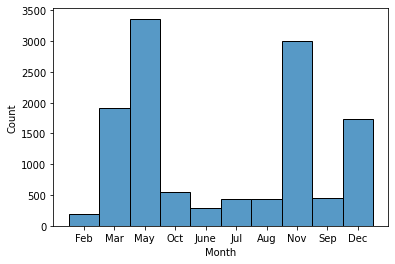

In [109]:
sns.histplot(data.Month);

May has the most data entries, but we're asked to exlude them from the training and test sets. This might be done because May entries would influence the model too much in comparison to other months with much less entries, but there could definitely be an argument made for removing November entries as well with this line of reasoning. 

Another possibility is that there's an issue with May entries specifically - for example, maybe the entries come from different years. This would also explain why there are so many more entries, and it could also be considered a source of data leakage if data from the future was used to train a model to predict on future interactions, rather than all the training data coming from the past.

With our current feature set and the description of the dataset, it is not possible to determine what the reason might be for excluding so much data.

Splitting the Data into Train and Test

In [110]:
df_test = data[data.Month.isin(["Feb", "Mar"])]
df_test.shape
df_test.Month.unique()

(2091, 18)

array(['Feb', 'Mar'], dtype=object)

In [111]:
df_train = data.drop(df_test.index)
df_train = df_train[df_train.Month != "May"]
df_train.shape
df_train.Month.unique()

(6875, 18)

array(['Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep', 'Dec'], dtype=object)

Checking distribution of target variable in train and test sets

In [112]:
print(f"Proportion of user journeys in training set that resulted in a purchase: {round(100*df_train.Revenue.mean(), 2)}%")
print(f"Proportion of user journeys in test set that resulted in a purchase: {round(100*df_test.Revenue.mean(), 2)}%")

Proportion of user journeys in training set that resulted in a purchase: 19.61%
Proportion of user journeys in test set that resulted in a purchase: 9.33%


While both the training and test set are imbalanced with respect to the target variable, the test set is significantly more imbalanced than the training set. This should be kept in mind when evaluating test set performance of our models, especially on the positive class.

## Feature Selection

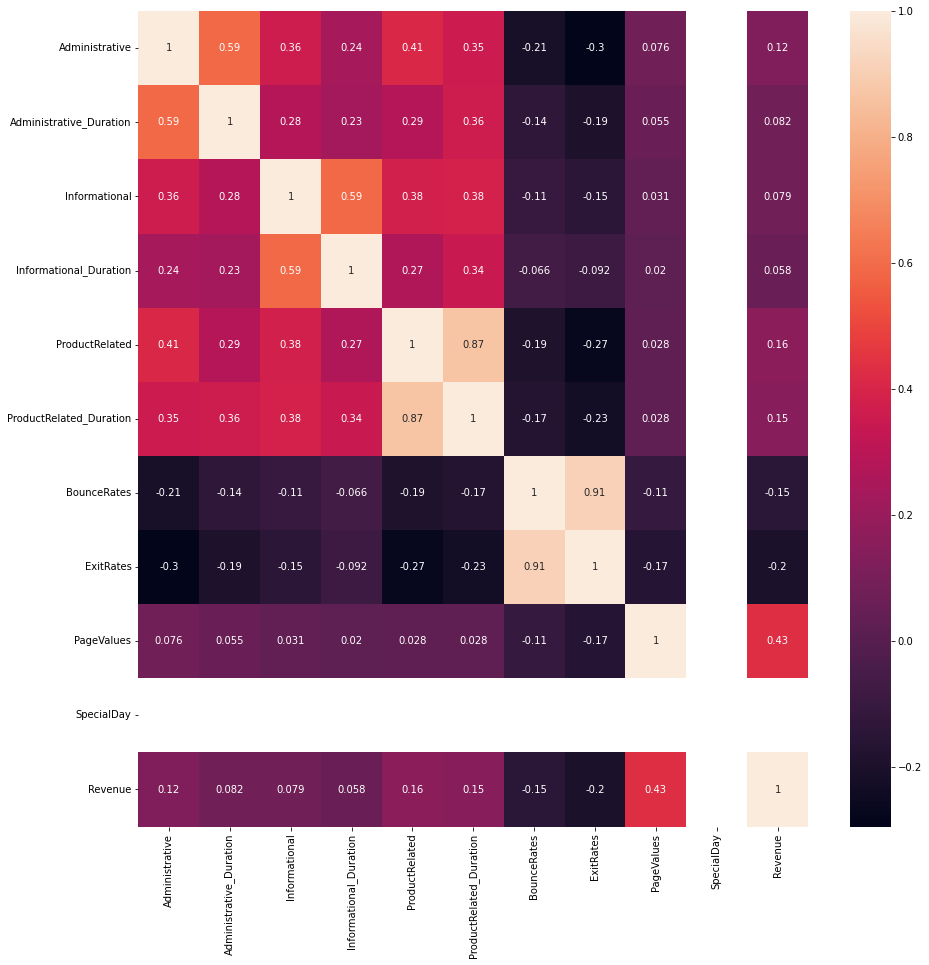

In [114]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_train[num_cols + ["Revenue"]].corr(), annot=True);

Examining SpecialDay feature

In [115]:
df_train.SpecialDay.unique()
df_test.SpecialDay.unique()

array([0.])

array([0. , 0.4, 0.8, 1. , 0.2, 0.6])

Although it seems that the SpecialDay variable might have some valuable information in the test set, our training set is limited to a single value of this feature, so it is useless and should be dropped.

In [116]:
df_train = df_train.drop("SpecialDay", axis=1)
df_test = df_test.drop("SpecialDay", axis=1)

Addressing Multicollinearity in our features

The features with the highest degree of correlation between them are: ProductRelated and ProductRelated_Duration; and ExitRates and BounceRates. Also highly correlated but to a lesser degree are Administrative and Administrative_Duration; as well as Informational and Informational_Duration.



Calculating VIF (Variance Inflation Factor) using Statsmodels library to confirm presence of multicollinearity

In [127]:
# Using functions from Statsmodels library
vif_test = add_constant(df_train[num_cols[:-1]])

pd.Series([variance_inflation_factor(vif_test.values, i) 
               for i in range(vif_test.shape[1])], index=vif_test.columns)

const                      4.906594
Administrative             1.880099
Administrative_Duration    1.691788
Informational              1.742435
Informational_Duration     1.608724
ProductRelated             4.673586
ProductRelated_Duration    4.650643
BounceRates                6.245947
ExitRates                  6.743894
PageValues                 1.041549
dtype: float64

While ProductRelated and ProductRelated_Duration have high VIFs as expected from their high correlation, BounceRates and ExitRates have the highest VIFs, over the standard cutoff of 5 for VIFs. 

Since ExitRates has the highest VIF, we'll check the VIF's again after excluding ExitRates.

In [125]:
vif_test = add_constant(df_train[num_cols[:-1]])
vif_test = vif_test.drop("ExitRates", axis=1)

pd.Series([variance_inflation_factor(vif_test.values, i) 
               for i in range(vif_test.shape[1])], index=vif_test.columns)

const                      2.340536
Administrative             1.852451
Administrative_Duration    1.689822
Informational              1.742398
Informational_Duration     1.608723
ProductRelated             4.592349
ProductRelated_Duration    4.639146
BounceRates                1.072942
PageValues                 1.016211
dtype: float64

Now all VIFs are under the desired cutoff, so we can try excluding ExitRates during our feature selection.

Comparing unique values of categorical columns found in train and test sets

In [144]:
for col in cat_cols:
    print(col, ": train - ", sorted(df_train[col].unique()))
    print(col, ": test - ", sorted(df_test[col].unique()))


Month : train -  ['Aug', 'Dec', 'Jul', 'June', 'Nov', 'Oct', 'Sep']
Month : test -  ['Feb', 'Mar']
OperatingSystems : train -  [1, 2, 3, 4, 5, 6, 7, 8]
OperatingSystems : test -  [1, 2, 3, 4, 7]
Browser : train -  [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13]
Browser : test -  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Region : train -  [1, 2, 3, 4, 5, 6, 7, 8, 9]
Region : test -  [1, 2, 3, 4, 5, 6, 7, 8, 9]
TrafficType : train -  [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 20]
TrafficType : test -  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
VisitorType : train -  ['New_Visitor', 'Other', 'Returning_Visitor']
VisitorType : test -  ['New_Visitor', 'Returning_Visitor']
Weekend : train -  [False, True]
Weekend : test -  [False, True]


Clearly, not all unique values of each categorical feature are present in both sets, so one-hot encoding will have to be performed by specifying categories found in original data, to avoid mismatch in array sizes between the train and test arrays.

### Summary of findings: feature selection and preprocessing decisions

To summarize, before modelling we must:

- Remove the `SpecialDay` column (only one value in training set, so zero predictive value)

- Remove `ExitRate` column to avoid multicollinearity (can also consider removing ProductRelated_Duration or some of the other highly correlated features and see effect on model performance)

- One-hot encode categorical columns (this will have to be done using all possible values found in original data, since both the training and test sets will have only a subset of all potential values)

- Scale numerical features (this will have to be done after splitting to avoid data leakage)



## Modelling

### Preprocessing

In [282]:
# Numerical features, excluding SpecialDay and ExitRates
numeric_features = ["Administrative", "Administrative_Duration", "Informational",
            "Informational_Duration", "ProductRelated", "ProductRelated_Duration",
            "BounceRates", "PageValues"]

# Categorical features, excluding Revenue because it's the target variable
categorical_features = ["Month", "OperatingSystems", "Browser", "Region", "TrafficType",
            "VisitorType", "Weekend"]

# Scaler for numerical features
numeric_transformer = StandardScaler()

# Define categories for one-hot encoder based on all unique categories of categorical features
categories = [sorted(data[col].unique()) for col in cat_cols]

# One-hot Encoder for categorical features
categorical_transformer = OneHotEncoder(categories=categories)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### Defining Models

In [315]:
# Logistic Regression model, accounting for imbalanced classes
log_clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("classifier", LogisticRegression(class_weight="balanced", max_iter=200))]
)

# Random Forest Classifier, not accounting for imbalanced classes
rf_clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("classifier", RandomForestClassifier(max_depth=5, class_weight="balanced", random_state=42))]
)

# Support Vector Machine, accounting for imbalanced classes
svm_clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("classifier", LinearSVC(class_weight="balanced", random_state=42, max_iter=50000))]
)

In [306]:
# Preparing train and test sets
X_test = data[data.Month.isin(["Feb", "Mar"])]
X_train = data.drop(X_test.index)
X_train = X_train[X_train.Month != "May"]
X_train = X_train.drop(columns=["SpecialDay", "ExitRates"])
X_test = X_test.drop(columns=["SpecialDay", "ExitRates"])

y_train = X_train.pop("Revenue")
y_test = X_test.pop("Revenue")

### Fitting models

In [320]:
log_clf.fit(X_train, y_train);

In [321]:
log_clf.score(X_test, y_test)

0.9378287900526064

In [322]:
rf_clf.fit(X_train, y_train);

In [323]:
rf_clf.score(X_test, y_test)

0.9497847919655668

In [324]:
svm_clf.fit(X_train, y_train);

In [325]:
svm_clf.score(X_test, y_test)

0.9378287900526064

### Evaluating Models

In [326]:
# Logistic Regression evaluation
y_pred = log_clf.predict(X_test)
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

array([[1813,   83],
       [  47,  148]])

              precision    recall  f1-score   support

       False       0.97      0.96      0.97      1896
        True       0.64      0.76      0.69       195

    accuracy                           0.94      2091
   macro avg       0.81      0.86      0.83      2091
weighted avg       0.94      0.94      0.94      2091



In [327]:
# Random Forest evaluation
y_pred = rf_clf.predict(X_test)
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

array([[1791,  105],
       [   0,  195]])

              precision    recall  f1-score   support

       False       1.00      0.94      0.97      1896
        True       0.65      1.00      0.79       195

    accuracy                           0.95      2091
   macro avg       0.82      0.97      0.88      2091
weighted avg       0.97      0.95      0.95      2091



In [328]:
# SVM evaluation
y_pred = svm_clf.predict(X_test)
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

array([[1814,   82],
       [  48,  147]])

              precision    recall  f1-score   support

       False       0.97      0.96      0.97      1896
        True       0.64      0.75      0.69       195

    accuracy                           0.94      2091
   macro avg       0.81      0.86      0.83      2091
weighted avg       0.94      0.94      0.94      2091



According to the paper associated with this dataset (https://link.springer.com/article/10.1007/s00521-018-3523-0), the purpose of this dataset was to be able to model online purchasing intention. This model could then be used to predict whether a user's purchasing intention and offer content (ie. discounts, promotional campaigns) to these users.

These particular users fall into the True Positive class, therefore our aim is to maximize true-positive rate (recall), which corresponds with maximizing the amount of True Positives and minimizing the amount of False Negatives.

For this reason, the most important metric in the classification report is the recall for the positive class, which in our models ranges from 0.75 to 1, the highest of which is associated with the random forest model. This means that this is our most useful model for this particular use case. 

With more hyperparameter optimization and perhaps a more complex model, we could try to also improve precision as long as recall is unaffected.

### Analyzing contribution of features to prediction

In [329]:
# Separating model from preprocessing pipeline in order use shap explainer
lr_model = LogisticRegression(class_weight="balanced", max_iter=200)
lr_model.fit(preprocessor.fit_transform(X_train), y_train)

rf_model = RandomForestClassifier(max_depth=5, class_weight="balanced", random_state=42)
rf_model.fit(preprocessor.fit_transform(X_train), y_train)

svm_model = LinearSVC(class_weight="balanced", random_state=42, max_iter=50000)
svm_model.fit(preprocessor.fit_transform(X_train), y_train)

LogisticRegression(class_weight='balanced', max_iter=200)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

LinearSVC(class_weight='balanced', max_iter=50000, random_state=42)

In [330]:
# Getting feature names after one-hot encoding for shap plot
enc = categorical_transformer.fit(X_train[categorical_features])
oh_feature_names = enc.get_feature_names_out(X_train[categorical_features].columns)
new_feature_names = np.concatenate((numeric_features, oh_feature_names))

print(new_feature_names)
len(new_feature_names)

['Administrative' 'Administrative_Duration' 'Informational'
 'Informational_Duration' 'ProductRelated' 'ProductRelated_Duration'
 'BounceRates' 'PageValues' 'Month_Aug' 'Month_Dec' 'Month_Feb'
 'Month_Jul' 'Month_June' 'Month_Mar' 'Month_May' 'Month_Nov' 'Month_Oct'
 'Month_Sep' 'OperatingSystems_1' 'OperatingSystems_2'
 'OperatingSystems_3' 'OperatingSystems_4' 'OperatingSystems_5'
 'OperatingSystems_6' 'OperatingSystems_7' 'OperatingSystems_8'
 'Browser_1' 'Browser_2' 'Browser_3' 'Browser_4' 'Browser_5' 'Browser_6'
 'Browser_7' 'Browser_8' 'Browser_9' 'Browser_10' 'Browser_11'
 'Browser_12' 'Browser_13' 'Region_1' 'Region_2' 'Region_3' 'Region_4'
 'Region_5' 'Region_6' 'Region_7' 'Region_8' 'Region_9' 'TrafficType_1'
 'TrafficType_2' 'TrafficType_3' 'TrafficType_4' 'TrafficType_5'
 'TrafficType_6' 'TrafficType_7' 'TrafficType_8' 'TrafficType_9'
 'TrafficType_10' 'TrafficType_11' 'TrafficType_12' 'TrafficType_13'
 'TrafficType_14' 'TrafficType_15' 'TrafficType_16' 'TrafficType_17'
 'T

73

In [331]:
explainer = shap.Explainer(lr_model, preprocessor.fit_transform(X_train), feature_names=new_feature_names, output_names=["No Purchase", "Purchase"])
shap_values = explainer(preprocessor.fit_transform(X_train))

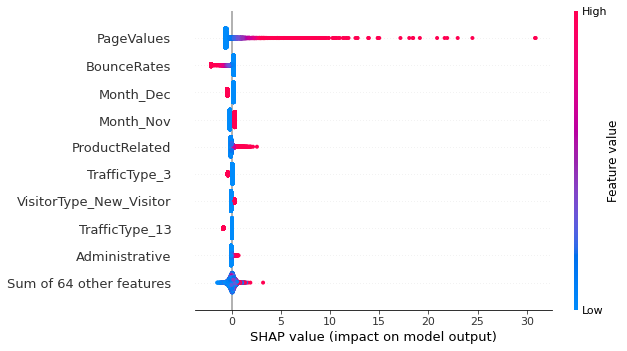

In [332]:
shap.plots.beeswarm(shap_values)

For the logistic regression model, `PageValues` has the most impact on the prediction when at a high value (a high positive contribution to the output). 

`BounceRates` has a relatively high negative contribution when at a high value. 

Interestingly, when the `Month` is December, the Month has a relatively low negative contribution to the prediction, whereas when it is November, the Month has a relatively low positive contribution. 

`ProductRelated` also has a moderate positive contribution when at high values. 

The other features have much less impact on the prediction, unless they're aggregated. 

In [333]:
explainer = shap.Explainer(svm_model, preprocessor.fit_transform(X_train), feature_names=new_feature_names, output_names=["No Purchase", "Purchase"])
shap_values = explainer(preprocessor.fit_transform(X_train))

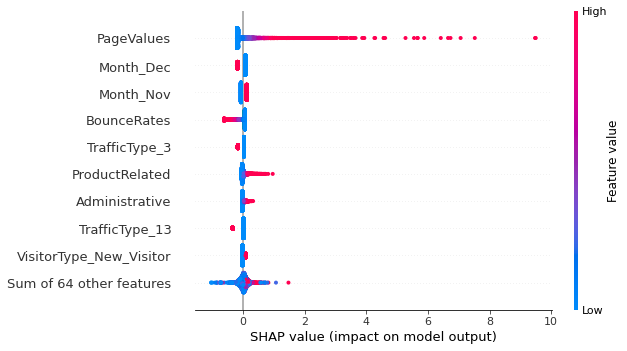

In [334]:
shap.plots.beeswarm(shap_values)

For the SVM model, the `PageValues` feature once again has the most extreme positive contribution to the prediction when at high values.

The other features share a similar impact trend as the logistic regression model.

In [340]:
# Visualization code taken from Week 6 assignment
export_graphviz(rf_model.estimators_[0], max_depth=5, out_file='tree.dot', 
                feature_names = new_feature_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
# MacOS: brew install graphviz
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

Image(filename = 'tree.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.899772 to fit


0

As can be seen from this vizualization of our random forest classifier, the best-performing model out of the 3, the tree starts by separating by `Region_8`, which is one of the one-hot encoded values of `Region`, then follows by separating by a one-hot encoded feature of `TrafficType` and `BounceRates`. 

The excellent performance of our model can be explained by the fact that our Random Forest Classifier is able to end with a significant amount of nodes with gini impurities of 0, indicating complete separation between the two classes.

# Task 2 - Customer Segmentation

## PCA

First, we will perform PCA in order to reduce the dimensionality of our features after one-hot encoding. This will improve the performance of our segmentation.

In [357]:
df_full = data.copy()
y = df_full.pop("Revenue")
df_full.head()

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  
0        1       1            1  Returning_Visitor    False  
1        2       1            2  Returning_Visitor    False  
2        1       9            3  Returning_Visitor    False  
3        2       2            4  Returning_Visitor    False  
4        3       1            4  Returning_Visitor     True

In [358]:
# PCA code taken from Week 8 assignment
pca = PCA(n_components=5, random_state=42, whiten=True)

X_scaled = preprocessor.fit_transform(df_full)
print(f"Shape before scaling, after preprocessing: {X_scaled.shape}")

# PCA
X_reduced = pca.fit_transform(X_scaled.toarray())

# Converting back to dataframe
X_reduced = pd.DataFrame(X_reduced, index=df_full.index)
print(f"Shape after PCA: {X_reduced.shape}")
X_reduced.head()

Shape before scaling, after preprocessing: (12330, 73)
Shape after PCA: (12330, 5)


0         1         2         3         4
0 -1.153539 -2.076512 -0.175055 -0.794200  2.724049
1 -0.626325  0.152306  0.054624  0.293845 -0.851538
2 -1.155949 -2.033336 -0.158347 -0.769605  2.702414
3 -0.795092 -0.496851 -0.063811 -0.122928  0.134711
4 -0.602764 -0.186022  0.107331  0.067129 -0.343967

In [359]:
print(f'Explained variation per principal component: {np.round(pca.explained_variance_ratio_, 2)}')

Explained variation per principal component: [0.26 0.09 0.09 0.08 0.07]


In [360]:
# Visualization functions taken from Week 8 assignment
def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

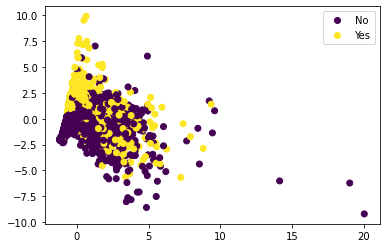

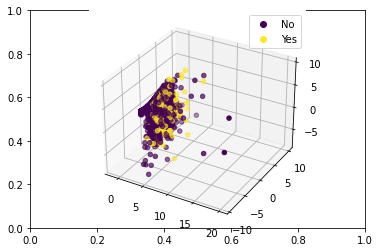

In [361]:
visualize_2pcs(X_reduced.to_numpy(), y[X_reduced.index])
visualize_3pcs(X_reduced.to_numpy(), y[X_reduced.index]) 

Here we just test our reduced data to see if we get comparable results to our non-reduced data.

In [372]:
def train_and_eval(X, y, train_index):
    # Splitting data according to months, as reflected in index
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]

    X_test = X.drop(train_index)
    y_test = y.drop(train_index)

    # Fitting model
    model = RandomForestClassifier(max_depth=5, class_weight="balanced", random_state=42)
    model.fit(X_train, y_train)

    # Evaluating model
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))



In [373]:
train_and_eval(X_reduced, y, df_train.index)

(5455, 5)
[[4405  490]
 [  75  485]]
              precision    recall  f1-score   support

       False       0.98      0.90      0.94      4895
        True       0.50      0.87      0.63       560

    accuracy                           0.90      5455
   macro avg       0.74      0.88      0.79      5455
weighted avg       0.93      0.90      0.91      5455



The recall has dropped from 1 to 0.87, but otherwise the performance has largely been conserved. Note that the number of samples is different than before in our confusion matrix, as we are doing PCA and segmentation on the entire dataset, including the samples in May.

## Clustering

In [378]:
# Silhouette score calculation code taken from Week 8 assignment utils file

for n_clusters in range(2, 12):
    clstr = KMeans(n_clusters=n_clusters, random_state=42)
    clstr_lbl = clstr.fit_predict(X_reduced)

    silhouette_avg = silhouette_score(X_reduced, clstr_lbl)

    print(f"For {n_clusters} clusters, the average silhouette score is: {silhouette_avg}")

For 2 clusters, the average silhouette score is: 0.4600135359751979
For 3 clusters, the average silhouette score is: 0.48979272768402315
For 4 clusters, the average silhouette score is: 0.5129549340439186
For 5 clusters, the average silhouette score is: 0.45758510741283553
For 6 clusters, the average silhouette score is: 0.46498304294434517
For 7 clusters, the average silhouette score is: 0.41110988016746114
For 8 clusters, the average silhouette score is: 0.4127595303633446
For 9 clusters, the average silhouette score is: 0.38540807145517
For 10 clusters, the average silhouette score is: 0.3890699201173082
For 11 clusters, the average silhouette score is: 0.3587063281019937


The silhouette score peaked at 4 clusters, so that's the amount we'll use.

In [379]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(X_reduced)

KMeans(n_clusters=4, random_state=42)

In [380]:
clustered_df = pd.DataFrame(km.labels_, columns=["cluster"])
clustered_df.head()

cluster
0        2
1        1
2        2
3        1
4        1

In [382]:
clustered_df.value_counts()

cluster
1          10037
2            919
0            739
3            635
dtype: int64

The K-means clustering results in one very large cluster and 3 other smaller but still sizable clusters.

Adding cluster label to dataframe

In [388]:
df_full["cluster_pca"] = km.labels_
df_full.head()

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  cluster_pca  
0        1       1            1  Returning_Visitor    False            2  
1        2       1            2  Returning_Visitor    False            1  
2        1       9            3  Returning_Visitor    False            2  
3        2       2            4  Returning_Visitor    False            1  
4        3       1            4  Returning_Visitor     True            1